# Hantush's well function for wells in leaky (semi-confined) aquifers

## Introduction
The second famous and important solution for transient flow to a wel was developed by Mahdi Hantush (1956) for extractin from a semi-confined aquifer. Again, the aquifer has uniform transmissivity $kD$ and storage coeffiicent of the aquifer $S$. The bottom of the aquifer is impervious. The aquifer is covered by a semi-pervious confining unit, a clay layer, say, that has a uniform resistance $c$ [d] against vertical flow and no storage. At the top of the confining unit, the head is kept uniform and contant in time.

![Hantush's case](./pictures/HantushSituation.png)

Figure: The situation according to Hantush: The aquifer is supplied from leakage from an (overlying layer) with constant head through a leaking confining unit with vertical hydraulic resistance c [T]. The straight horizontal line is the head in the overlying unit, the curve line is the head in the underlying aquifer. The drawdown is s. Without the well, the head in the two layers is assumed zero.

The partial differential equation for this flow system is almost the same as that for the flow in a confined aquifer solved by Theis, it only adds flow through the overlying confining unit that is governed by the head difference across this unit:

Partial differential equation solved by Theis (1935):

$$ kD \left( \frac {\partial^2 \phi} {\partial r^2} + \frac 1 r \frac {\partial \phi} {\partial r} \right) = S \frac {\partial \phi} {\partial t} $$

Partial differential equation solved by Hantush (1956):

$$ kD \left( \frac {\partial^2 \phi} {\partial r^2} + \frac 1 r \frac {\partial \phi} {\partial r} \right)- \frac {\phi - h} c = S \frac {\partial \phi} {\partial t} $$

The initial conditions are the same for both solutions, i.e. all heads zero at $t=0$.The boundary conditions are the same at the well face
$$ \lim_{ r \rightarrow 0} Q(r) = -2 \pi r kD \frac {\partial \phi} {\partial r} = Q_0 $$ 

And at infinity
$$ \phi (r \rightarrow \infty, t) = 0 $$

And for the head above the confining unit, $$ h = 0 $$

This reduces Hantush's partial differential equation to
$$ \frac {\partial^2 \phi} {\partial r^2} + \frac 1 r \frac {\partial \phi} {\partial r} - \frac \phi {\lambda ^2} = S \frac {\partial \phi} {dt} $$

with
$$ \lambda^2 = kDc $$

The solution that Hantush came up with in 1956 mathematically reads:

$$ s(r, t) = \frac Q {4 \pi kD} \intop_u^\infty \frac 1 y \exp \left( -y - \frac 1 y \left( \frac {r} {2 \lambda} \right)^2 \right) dy$$

with, like with the Theis equation:  $$ u = \frac {r^2 S} { 4 kD t } $$

It is immediately seen that when the confining unit becomes impermeable, i.e. its vertial resistance $c \rightarrow \infty$ and so $\lambda \rightarrow \infty$, the solution of Hantush reduces to that of Theis. What is not obvious from its mathematical form, is that when $t \rightarrow \infty$ the solution reduces to that for the steady solution for flow to a well in a leaky aquifer:

$$ s(r) = \frac Q {2 \pi kD} K_0 \frac r \lambda $$

with $ K_0 $ the well-known bessel function or zero order of the second kind. So that, for sufficiently large times we have

$$ K_0 \frac r \lambda = 2 \lim_{u\rightarrow 0} \left[\intop_u^\infty \frac 1 y \exp \left( -y - \frac 1 y \left( \frac r {2 \lambda} \right)^2 \right) dy \right] $$

which we will verify numerically.

## Implementing Hantush's well function

There exist different approaches, both by numerical integration and as development of a (double) power series, to implement this function that were elaborated in a number of papers because it is not obvious how to compute the function accurately under all circumstances. Nevertheless numerical integration is easy and works well, especially with the powerful tools like Python that we nowadays have at our finger tips.

We implement the Hantush well function as $Wh(u,\rho)$, where $\rho = r/\lambda$.

A mathematically more sound approach would be to develop the function as $Wh(\tau,\rho)$ where $\tau = \frac S {kD} t$. This is more mathematically sound because then both parameters $\tau$ and $\rho$ are completely independent, the first depending only on time and the second only on distance, whereas in the solution $Wh(u, \rho)$ u still depends on time and distance, and therefore, the two parameters are not independent. Nevertheless we'll stick with Hantush's approach, i.e. use u and $\rho$ to allow one-to-one comparison with the solution of Theis, which is just a limiting case of that of Hantush.

The implementation by direct numerical integration can be done as follows:

In [1]:
import numpy as np
import matplotlib.pylab as plt

In [2]:
#%%writefile wells.py  # remove first # to write this as file "wells.py" to disk

import pdb
import numpy as np

from scipy.special import expi
def W(u): return  -expi(-u)  # Theis

def wh(u, rho):
    """Returns Hantush's well function values

    Note: works only for scalar values of u and rho

    Parameters:
    -----------
    u : scalar  (u= r^2 * S / (4 * kD * t))
    rho : sclaar (rho =r / lambda, lambda = sqrt(kD * c))
    Returns:
    --------
    Wh(u, rho) : Hantush well function value for (u, rho)
    """
    try:
        u =float(u)
        rho =float(rho)
    except:
        print("u and rho must be scalars.")
        raise ValueError()
        
    LOGINF = 2
    y = np.logspace(np.log10(u), LOGINF, 1000)
    ym = 0.5 * (y[:-1]+  y[1:])
    dy = np.diff(y)
    w = np.sum(np.exp(-ym - (rho / 2)**2 / ym ) * dy / ym)
    return w


def Wh(U,Rho):
    """Returns multiple values of Hantush's well function.
    
    Parameters:
    -----------
    U : ndarray with values of u
    Rho : ndarray with values of rho
    
    Returns:
    --------
    well function values for all combinations of U and Rho in an ndarray of shape (Nrho, Nu)
    """
    U   = np.array(U,   dtype=float).ravel()  # converts U to shape ([)1, Nu)
    Rho = np.array(Rho, dtype=float).ravel()  # convers V to shape (Nr, 1)
    w = np.zeros((len(Rho), len(U))) *  np.NaN     # initialize array w of shape [Nr, Nu]
    for iu, u in enumerate(list(U)):
        for ir, rho in enumerate(Rho):
            w[ir, iu] = wh(u, rho)
    return w

The first function (lowercase `wh`) only takes scalar inputs and produces a single scalar output. The second, `Wh`, with captial W, takes multiple inputs of both `u` and `rho` and uses the first function to repeatedly to produce an output for each combination of `u` and `rho`. The result is an array of shape (Nrho, Nu), that is with in each row all the values of `Wh` one `rho` and all `u`, or, in each column the values of `Wh` for one u and all `rho`.

The next step is to produe the type curves for the Hantush well function. That is, cruves of `Wh` as a function of `u` for separately for each value of `rho`. We expect to see three characteristics:

1. Hantush reduces to Theis for $\lambda \rightarrow \infty$
2. The Hantush curves become stationary for sufficiently large times.
3. The Hantush curves stationary values should match $2 K_0 (r/\lambda)$

Here are some values from the table of Kruseman and De Ridder (1994, p298-299) to verify our implementation

In [3]:
U = 4.0 * 10. ** np.array([-6, -5, -4, -3, -2, -1, 0])
Rho = [0.06, 0.6, 6.]
# The NaNs are not in the table of KrDR
whantush =np.array([[ 5.87,   5.87,   5.83,  4.74,    2.66,  0.702, np.NaN],
                   [  1.55,   1.55,   1.55,  1.55,    1.52,  0.621, np.NaN],
                   [2.5e-3, 2.52e-3, 2.5e-3, 2.5e-3, 2.5e-3, 2.5e-3,  6e-3]])

w = Wh(U, Rho)

# Neatly print out the resuls for convenient comparison between tabled and computed valuues of Wh(u, rho)
print("Values of u ---->"+12*" ", end=   "")
print((" {:10.3g}"*len(U)).format(*U), end="")
print()
for ir, r in enumerate(Rho):
    print("rho = {:10.3g}, wh table".format(r), end=" : ")
    print((" {:10.3g}"*len(U)).format(*whantush[ir,:]), end="")
    print()
    print("rho = {:10.3g}, computed".format(r), end=" : ")
    print((" {:10.3g}"*len(U)).format(*w[ir,:]), end="")
    print()
    print()

Values of u ---->                  4e-06      4e-05     0.0004      0.004       0.04        0.4          4
rho =       0.06, wh table :        5.87       5.87       5.83       4.74       2.66      0.702        nan
rho =       0.06, computed :        5.87       5.87       5.83       4.74       2.66      0.702    0.00378

rho =        0.6, wh table :        1.55       1.55       1.55       1.55       1.52      0.621        nan
rho =        0.6, computed :        1.56       1.56       1.56       1.56       1.52      0.621    0.00371

rho =          6, wh table :      0.0025    0.00252     0.0025     0.0025     0.0025     0.0025      0.006
rho =          6, computed :     0.00249    0.00249    0.00249    0.00249    0.00249    0.00249   0.000586



Which shows that our implementation works if sufficient accuracy over the entire range of tabled values, so that we can use it.
Notice that the call to function Wh( ) also implies that the function wh( ) is correct, becaues Wh( ) calls wh( ) for every combination of u and rho.

## Generating type curves for the Theis and Hantush well functions

Type curves are graphs of the well function versus u or rather $1/u$ as explained when we dealt with the Theis well function. Type curves are, in fact, the dimensionless drawdown versus timensionless parameter u. In the case of leaky aquifers, we have a separte type curve for every value of $r/\lambda$.

With both the Theis and the Hantush well function available, generating type curves is straightforward. It is done below.

The value of $2 K(\frac r \lambda)$ should match the stationary value of the Hantush drawdown. We show these values as red dots with the type curves.

In [4]:
from scipy.special import expi
def W(u): return  -expi(-u)  # Theis

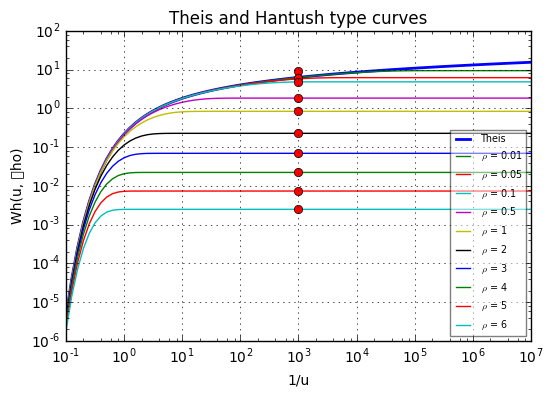

In [5]:
U = np.logspace(-7, 1, 81)
Rho = [0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 6]

w = Wh(U, Rho)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set(xlabel='1/u', ylabel='Wh(u, \rho)', xscale='log', yscale='log',
      title='Theis and Hantush type curves')
ax.grid(True)
ax.plot(1/U, W(U), label='Theis', linewidth=2)

for ir, rho in enumerate(Rho):
    label = r"$\rho$ = {:g}".format(rho)
    ax.plot(1/U, w[ir,:], label=label)
ax.legend(loc='best', framealpha=0.5, fontsize='x-small')

# Also show that the bessel function K0(rho) = 2 * Wh(1/u = infty, rho)
from scipy.special import k0 # import bessel funcion K0()

for rho in Rho:
    ax.plot(1/np.median(U), 2 * k0(rho), 'ro')
plt.show()

One sees that
1. indeed the Hantush drawdowns become stationaary after some time, while the Theis drawdown does not.
2. the Hantush curve approaches the Theis curve the lower $\rho$, i.e. the larger $\lambda = \sqrt{kD\,c}$, meaning the less permeable the confining unit is.
3. the red dots, of $2\,K_0(\rho)$ fall on the horizontal (= stationary) part of the Hantush curves.


With the Hantush well function carefully implemented and checked, we can use it in similar exercises as we did with the Theis solution. This does not add much insight. There are however some important aspects.

1. Even if one thinks that aquitards are impervious, making aquifers fully confined, this may not be so in reality. It may well be that the stationary phase has not het been reached, i.e. the pumping test has been too short to evaluate the effects of leakage.
2. Leakage implies that water is drawn into the aquifer due to our pumping. That also means that if the pumping test shows a leveling off of the drawdown, that this may not be the whole story. Namely, if water is drawn from an overlying aquifer, especially un unconfined (phreatic) one with a storage coefficient (speciic yield) that is much larger than the storage coefficient (elastic storage) of the aquifer below the confining unit, we may likely have a delayed yield, which we'll look into later. It is important, because if your pumping test is too short, you won't see the delayed yield and you will not see that the head in the overlying unconfined aquifer drops. It will, but it takes more time. And over time, the drawdown in the overlying unconfined aquifer may well be the most important impact on the enviroment and on your long-term well capacity and your groundwater resource altogether.
3. Seldom is a confining unit perfeclty impervious!

### Pumping test in a leaky aquifer

Kresemand and De Ridder (2002) present pumping test in a semi-confined aqufier, on a site called "Dalem" The subsuface shows a semi-pervious unit that consist of Holocene layers down to about 14 m below ground surface. Below this a Pleistocen aquifer is encountered consisting of different sands down to about 44 m. Finally a Pleistocen formation is hit consisting of clays, which are considered to form an aquiclude that closes off the bottom of the aquifer. The pumped screen was installed between 11 and 24 m below ground surface and pumped during 24 hours at a rate of 761 m2/d.

The drawdown data are given below. The keys of the dict, like "30_14" contain both the distance from the well and the depth below ground surface in m. The first column of the data contain the time in d since the start of the pump. The second column contains the drawdown in m.

In [6]:
keys = ['30_14', '60_14', '90_14', '120_14']

"""Data of the pumping test Dalem, see Kruseman and De Ridder (2000), p75, p84"""
H = {}
H['30_14'] = np.array([
                        [0.0153, 0.138],
                        [0.0181, 0.141],
                        [0.0229, 0.150],
                        [0.0292, 0.156],
                        [0.0361, 0.163],
                        [0.0458, 0.171],
                        [0.066, 0.180],
                        [0.0868, 0.190],
                        [0.125, 0.201],
                        [0.167, 0.210],
                        [0.208, 0.217],
                        [0.250, 0.220],
                        [0.292, 0.224],
                        [0.333, 0.228]])

H['60_14'] = np.array([
                         [0.0188, 0.081],
                         [0.0236, 0.089],
                         [0.0299, 0.094],
                         [0.0368, 0.101],
                         [0.0472, 0.109],
                         [0.0667, 0.120],
                         [0.0882, 0.127],
                         [0.125, 0.137],
                         [0.167, 0.148],
                         [0.208, 0.155],
                         [0.250, 0.158],
                         [0.292, 0.160],
                         [0.333, 0.164]])

H['90_14'] = np.array([
                         [0.0243, 0.069],
                         [0.0306, 0.077],
                         [0.0375, 0.083],
                         [0.0468, 0.091],
                         [0.0674, 0.100],
                         [0.0896, 0.109],
                         [0.125, 0.120],
                         [0.167, 0.129],
                         [0.208, 0.136],
                         [0.250, 0.141],
                         [0.292, 0.142],
                         [0.333, 0.143]])

H['120_14'] = np.array([
                          [0.0250, 0.057],
                          [0.0313, 0.063],
                          [0.0382, 0.068],
                          [0.0500, 0.075],
                          [0.0681, 0.086],
                          [0.0903, 0.092],
                          [0.125, 0.105],
                          [0.167, 0.113],
                          [0.208, 0.122],
                          [0.250, 0.125],
                          [0.292, 0.127],
                          [0.333, 0.129]])

In [7]:
dist = {}
for key in H.keys():
    dist[key] = float(key.split('_')[0])

In [8]:
dist["30_14"]


30.0

Your first task is to

1. show the data graphically, both on half log as on double log scales.
2. Explain whether the data show that the aquier is semi-confined or confined.
3. Show the drawdowns versus time $t$ and versus $t/r^2$
4. Explain what the difference is between the two graphs (versus $t$ or versus $t/r^2$)

Next step is to interprete the test to determine the transmissivity $kD$, the storage coefficient, $S$, and the characteristic length $\lambda = \sqrt{kD \, c}$ and, from that the vertical hydraulic resistance of the overlaying holocene layers.

To do this:
1. Start with the Hantush type curves, i.e. $Wh(u, \rho)$ versus $1/u$
2. Add to that graph the measurements, but multiply the measured drawdowns by a factor$A$ and the $t/r^2$ values by a factor $B$.
3. Move the points on the graph by adapting the values of $A$ and $B$ and redrawing the graph intil the measurements fit as well as possible to the type curves. They should because the shape of the measurements and the correct type curves must be the same on double log graphs. Multiplying by $A$ moves the points vertically, and multiplying the values of $t/r^2$ by $B$ moves the points horizontally.
4. Once the points fit a type curve, determine the requested aquifer properties using the values of $A$ and $B$ that made the points fit the type curve.

In [9]:
import matplotlib.pylab as plt
import numpy as np

In [10]:
H['30_14'][:,0]

array([ 0.0153,  0.0181,  0.0229,  0.0292,  0.0361,  0.0458,  0.066 ,
        0.0868,  0.125 ,  0.167 ,  0.208 ,  0.25  ,  0.292 ,  0.333 ])

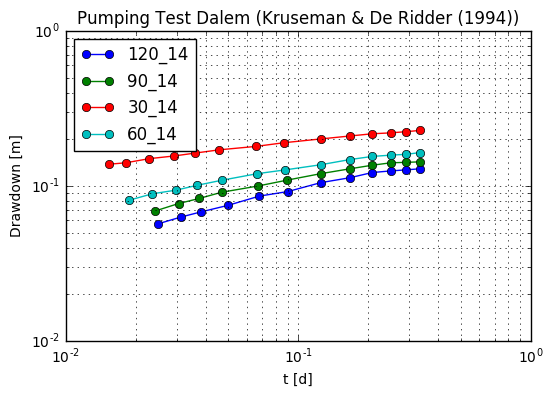

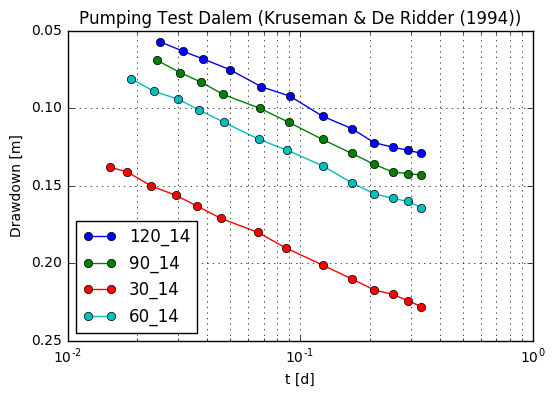

In [11]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.set(xlabel='t [d]', ylabel='Drawdown [m]', xscale='log', yscale='log',
      title='Pumping Test Dalem (Kruseman & De Ridder (1994))')

for key in H.keys():
    ax1.plot(H[key][:,0], H[key][:,1], 'o-', label=key)
#ax1.invert_yaxis()
ax1.grid(True, 'both')
ax1.legend(loc='best')
plt.show()


fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.set(xlabel='t [d]', ylabel='Drawdown [m]', xscale='log', yscale='linear',
      title='Pumping Test Dalem (Kruseman & De Ridder (1994))')

for key in H.keys():
    ax2.plot(H[key][:,0], H[key][:,1], 'o-', label=key)
ax2.invert_yaxis()
ax2.grid(True, 'both')
ax2.legend(loc='best')
plt.show()


1. The top figure shows already that the data only cover a small portion of the Hantush type curves. This implies that the accuracy to determine a unique match between the measurements and the type curves will be of limited accuracy.
2. For the drawdown on half-log scale, i.e. the second figure, we expect that for a truly confined aquifer these lines will stay straight lines with increasing times. The data show a small deviation from the straigt lines by the end of the test, but the curves do not yet show their horizontal branch, which would be visible after the drawdown has become stationary. Hence the test was too short and should probably have been extended to 10 days, which we will verify later on. We need this deviation towards stationarity to uniquely determine the spreading length $\lambda$, which will be, therefore of limited accuracy. Ok, we can do nothing more than the best we can.

The solution for the Theis drawdown curves yields straight lines after some initial time, that are described by

$$ s = \frac Q {4 \pi kD } \ln \left( \frac {2.25 kD} S \frac t {r^2} \right) $$

The first idea is to make a graph of the drawdown versus $t/r^2$, which should cause all straight-line parts of the drawdown curves to fall on top of oneanother. This tells whether the same aquifer parameters are valid for all piezometers, or allows us to take the best evarage situation.

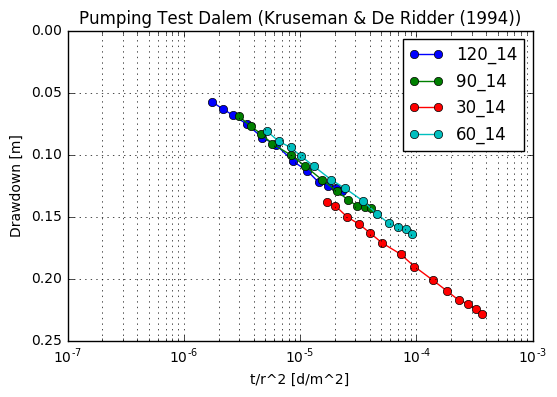

In [12]:
# Plot the four drawdowns as function of t/r^2
fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.set(xlabel='t/r^2 [d/m^2]', ylabel='Drawdown [m]', xscale='log', yscale='linear',
        ylim=(0, 0.25), xlim=(1e-7, 1e-3),
      title='Pumping Test Dalem (Kruseman & De Ridder (1994))')

for key in H.keys():
    #print(key, dist[key])
    ax3.plot(H[key][:,0]/dist[key]**2, H[key][:,1], 'o-', label=key)

ax3.invert_yaxis()
ax3.grid(True, 'both')
ax3.legend(loc='best')
plt.show()


If we extend a straight line through the three closely spaced lines, is intersects zero drawdown at $t/r^2 = 2.5e-7$.
The second conclusion is that the drawdown increase per log cycle is 0.075m per log cycle.

With the drawdown according to the log approximation of the Theis drawdown given above, we have

$$ \frac {2.25 kD} S \frac t {r^2} = 1 $$

So that

$$ \frac {kD} S = \frac 1 {2.25 \times 2.5\times 10^{-7}} = 1.77\times 10^6 $$

The increase of the drawdown per log cycle yields

$$ \Delta s = \frac Q {4 \pi kD} \ln 10 = 0.075 $$

$$ kD = \frac {761 \ln(10)} {4 \pi \times 0.075} = 1860 \, m^3/d $$

$$ S = 1860\, /\, 1.77\times10^6 = 0.0015 $$

This work out was one for a confined aquifer. We don't get much further using the graphs on half-log scales, so that we can't really figure out the $\lambda$ and, therfore the $c$ value.

Following Kruseman and De Ridder (2000) we'll continue using graphs on double log.

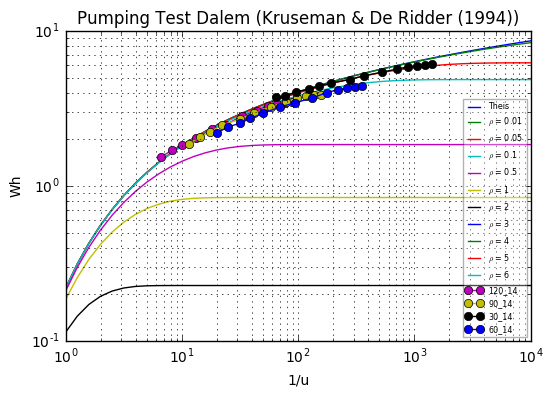

In [13]:
U = np.logspace(-7, 1, 81)
Rho = [0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 6]

w = Wh(U, Rho)
fig4 = plt.figure()
ax4 = fig4.add_subplot(111)
ax4.set(xlabel='1/u', ylabel='Wh', xscale='log', yscale='log',
        xlim=(1.e0,1.e4), ylim=(1e-1,1e1),
      title='Pumping Test Dalem (Kruseman & De Ridder (1994))')
ax.grid(True)

ax4.plot(1/U, W(U), label='Theis', linewidth=1)

for ir, rho in enumerate(Rho):
    label = r"$\rho$ = {:g}".format(rho)
    ax4.plot(1/U, w[ir,:], label=label)
#ax4.legend(loc='best', framealpha=0.5, fontsize='x-small')

A = 3.8e6  # value obtained after trial and error
B = 0.27e2 # value obtained after trial and error

for key in H.keys():
    ax4.plot(A * H[key][:,0]/dist[key]**2, B * H[key][:,1], 'o-', label=key)
ax4.grid(True, 'both')
ax4.legend(loc='best', framealpha=0.3, fontsize='xx-small')
plt.show()

We multiplied the values of $t/r^2$ by $A=3.8e6$ and the drawdown by $B = 0.27e2$ to shift the data points such that they fall as well as possible on one of the type curves, in this case the one with $r/\lambda = 0.05$ for the black points and $r/\lambda = 0.1$ for the green points. So we have now

$$ \frac 1 u = A  \frac t {r^2} $$
$$ \frac {4 kD} S \frac  t {r^2} = A \frac t {r^2} $$
$$ \frac {kD} S = \frac A 4 = 0.25 \times 3.8 \times 10^6 = 0.95\times 10^6$$

We also have 

$$  W = B s $$
$$ W  = B \,\frac Q {4 \pi kD} W $$



$$ kD =B \frac Q {4 \pi } = 0.27\times10^2  \frac {761} {4 \pi } = 1635 $$


$$ S = \frac {kD} {0.95\times10^6} = \frac {1635} {0.95 \times 10^6} = 0.0017 $$

Already we have the $\lambda$ values from the type curves that fitted best the drawdown for the individual piezometers. That is $r / \lambda = 0.05$ for the piezometer at $r=30$ m, and $r / \lambda = 0.1$ for the piezometer at 60 m form the well. This yields $\lambda = 600$ m for the first and also $\lambda = 600$ m for the second.  That is $c = 600^2 / 1635 = 220$ d for both piezometers.

### Results of the pumping test

In this second workout of the pumping test we conclude the following rounded aquifer properties

kD = 1600 m2/d

S  = 0.0017

$\lambda$ = 600 m

c = 220 d

There is, therefore, some difference between the two methods employed here. But these can be attributed to the too duration of pumping test. It should have lasted a week instead of only 24 hours. This is a lesson, a pumping test should always be prepared by modeling, so that, even with only coarsely estimated parameters, one can come to a projecten of what groundwater is to be expected, and thus, what the duration (and the capacity) of the pumping must be to obtain the best result for interpretation afterwards.

If we now look back in the book of Kruseman and De Ridder, they obtain with these data

kD = 1730 m2/d

S = 0.0019

$\lambda$ = 900 m

c = 470 d

One may remark that these results are essentially the same given the uncertainty due to the short durationof the pumping test and also because Kruseman and De Ridder interpreted only piezometer and we did two.

The difference with the first method is small with $kD = 1860$ m2/d and $S = 0.0015$, but we could not determine the spreading length $\lambda$ with that method.